In [202]:
import numpy as np
import scipy.spatial.distance
import scipy.stats
import scipy.optimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
#from bayesian_optimization_util import plot_approximation, plot_acquisition
import sys
sys.path.append("/Users/erio/Dropbox/URP project/Code/bayesian-machine-learning/bayesian-optimization")
from bayesian_optimization_util import plot_approximation, plot_acquisition

import matplotlib.pyplot as plt


In [56]:
def RBF(x,y,params=[1,1]):
    return params[0] * np.exp(-0.5*params[1]* scipy.spatial.distance.cdist(x,y)**2)


print(RBF(np.array([[1,2]]),np.array([[3,4]])))
print(RBF([[1]],[[2]]))
print(RBF(np.array([[1,0],[1,1]]), np.array([[1,0],[1,1]])))

[[0.01831564]]
[[0.60653066]]
[[1.         0.60653066]
 [0.60653066 1.        ]]


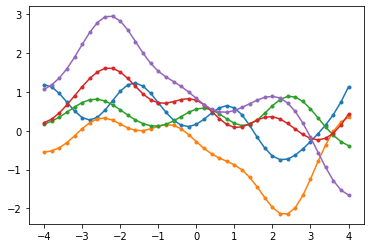

In [66]:
n_samples = 41
n_functions = 5

#Independent variable samples
X = np.expand_dims(np.linspace(-4,4, n_samples), 1) # 41 points of 1-dimension
kernel = RBF(X,X) # prior kernel of size 41x41

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(mean = np.zeros(n_samples),
                                  cov = kernel,
                                  size = n_functions)

for i in range(n_functions):
    plt.plot(X,ys[i],marker='o',markersize=3)
plt.show()

In [128]:
def posterior(Xnew, X, y, params=[1,1], noise_var=0.01):
    #print(Xnew.shape, X.shape, y.shape)
    cov_Xnew_X = RBF(Xnew, X, params)
    cov_X_X = RBF(X, X, params) + noise_var**2 * np.eye(X.shape[0])
    cov_Xnew_Xnew = RBF(Xnew, Xnew, params)
    print(cov_Xnew_X.shape, cov_X_X.shape, cov_Xnew_Xnew.shape)
    
    inv_cov_X_X = scipy.linalg.solve(cov_X_X, np.eye(X.shape[0]))
                                                                 
    post_mu = np.zeros(shape=(Xnew.shape[0],1)) + cov_Xnew_X @ inv_cov_X_X @ (y - np.zeros(shape=(X.shape[0],1)))
    post_cov = cov_Xnew_Xnew - cov_Xnew_X @ inv_cov_X_X @ cov_Xnew_X.T
    
    return post_mu.squeeze(), post_cov

In [224]:
# def f(x):
#     return np.sin(np.pi*x)

# def f(chromosome):
#     #return np.sin(x)
#     """F5 Rastrigin's function
#     multimodal, symmetric, separable"""
#     #print(chromosome)
#     fitness = 10*len(chromosome)
#     for i in range(len(chromosome)):
#         fitness += chromosome[i]**2 - (10*np.cos(2*np.pi*chromosome[i]))
#     return fitness

# def noise_fn(shape, noise=1):
#     return noise*np.random.normal(0,1,shape)

def f(x, noise=0.2):
    val = -np.sin(3*x) - x**2 + 0.7*x + noise * np.random.randn(*x.shape)
    return val.ravel()

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

print(X_init.shape, Y_init.shape)
print(Y_init)

(2, 1) (2,)
[-1.21989908 -0.68077332]


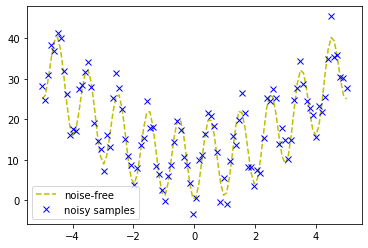

In [188]:
X = np.linspace(-5,5, 100)
y = np.array(list(map(f,X.reshape(-1,1))))
y_noisy = y + noise_fn(y.shape, noise=3)
plt.plot(X,y, 'y--', label='noise-free')
plt.plot(X,y_noisy, 'bx', label='noisy samples')
plt.legend()

In [189]:
n1 = 15
n2 = 300
ny = 5
domain = (-3,3)

#X1 = np.random.uniform(domain[0],domain[1], size=(n1,1))
X1 = np.linspace(-5,5,n1).reshape(-1,1)
y1 = np.array(list(map(f,X1))).reshape(-1,1)
print(X1.shape, y1.shape)

X2 = np.linspace(domain[0]-2,domain[1]+2, n2).reshape(-1,1)
mu2, sigma2 = posterior(X2, X1, y1)
print(mu2.shape, sigma2.shape)

y2 = np.random.multivariate_normal(mean = mu2,
                                  cov = sigma2,
                                  size = ny)

y2.shape

(15, 1) (15, 1)
(300, 15) (15, 15) (300, 300)
(300,) (300, 300)


(5, 300)

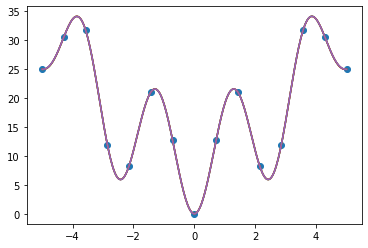

In [190]:
for i in range(ny):
    plt.plot(X2,y2[i])
plt.scatter(X1,y1)
plt.show()

In [225]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * scipy.stats.norm.cdf(Z) + sigma * scipy.stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [230]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    print(X_sample.shape, Y_sample.shape)
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = scipy.optimize.minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [231]:
noise = 0.2

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise**2)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

(2, 1) (2,)


ValueError: `f0` passed has more than 1 dimension.

<Figure size 864x2160 with 0 Axes>